In [99]:
import pandas as pd
from os.path import join, exists
from os import getcwd, listdir
from utils.get_column import GetColumn

In [100]:
demographics_location = join(getcwd(),"data", "xpt", "Demographics")
demo_location = join(demographics_location, "demo_h.xpt")

if exists(demo_location):
    frame = pd.read_sas(demo_location)
    frame.head()
else:
    raise ValueError(f"{demo_location} does not exist")

In [101]:
c = GetColumn({
    'id': 'SEQN',
    "gender": "RIAGENDR",
    "age": "RIDAGEYR",
    "income": "INDFMIN2"
})

In [102]:
selected_columns = frame[c.all]

In [103]:
selected_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10175 entries, 0 to 10174
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      10175 non-null  float64
 1   RIAGENDR  10175 non-null  float64
 2   RIDAGEYR  10175 non-null  float64
 3   INDFMIN2  10052 non-null  float64
dtypes: float64(4)
memory usage: 318.1 KB


In [104]:
selected_columns.describe()

,SEQN,RIAGENDR,RIDAGEYR,INDFMIN2
count,10175.000000,10175.000000,1.017500e+04,10052.000000
mean,78644.000000,1.508305,3.148413e+01,10.505969
std,2937.413829,0.499956,2.442165e+01,13.643064
min,73557.000000,1.000000,5.397605e-79,1.000000
25%,76100.500000,1.000000,1.000000e+01,5.000000
50%,78644.000000,2.000000,2.600000e+01,7.000000
75%,81187.500000,2.000000,5.200000e+01,14.000000
max,83731.000000,2.000000,8.000000e+01,99.000000


In [105]:
selected_columns.nunique()

SEQN        10175
RIAGENDR        2
RIDAGEYR       81
INDFMIN2       16
dtype: int64

In [106]:
(selected_columns.isna().sum() / selected_columns.count()) * 100

SEQN        0.000000
RIAGENDR    0.000000
RIDAGEYR    0.000000
INDFMIN2    1.223637
dtype: float64

Since 1% is empty it is safe to drop it

In [107]:
selected_columns = selected_columns.dropna()

In [108]:
(selected_columns.isna().sum() / selected_columns.count()) * 100

SEQN        0.0
RIAGENDR    0.0
RIDAGEYR    0.0
INDFMIN2    0.0
dtype: float64

In [109]:
selected_columns[c['gender']] = selected_columns[c['gender']] - 1
selected_columns[c['gender']]

0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
10170    0.0
10171    1.0
10172    1.0
10173    0.0
10174    0.0
Name: RIAGENDR, Length: 10052, dtype: float64

In [110]:
target_location = join(getcwd(), 'target.csv')
target = pd.read_csv(target_location)
target.head()

,SEQN,DXXNK_TSCORE,CLASSES,TARGET_BINARY
0,73557.0,NaN,NaN,NaN
1,73558.0,-0.358333,normal,0.0
2,73559.0,NaN,NaN,NaN
3,73561.0,-1.133333,osteopenia,1.0
4,73562.0,0.316667,normal,0.0


In [111]:
target.shape, selected_columns.shape

((3708, 4), (10052, 4))

In [112]:
final_frame = selected_columns.merge(target, on=c['id'])

In [113]:
final_frame.head()

,SEQN,RIAGENDR,RIDAGEYR,INDFMIN2,DXXNK_TSCORE,CLASSES,TARGET_BINARY
0,73557.0,0.0,69.0,4.0,NaN,NaN,NaN
1,73558.0,0.0,54.0,7.0,-0.358333,normal,0.0
2,73559.0,0.0,72.0,10.0,NaN,NaN,NaN
3,73561.0,1.0,73.0,15.0,-1.133333,osteopenia,1.0
4,73562.0,0.0,56.0,9.0,0.316667,normal,0.0


In [114]:
final_frame = final_frame.dropna()

In [115]:
final_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3096 entries, 1 to 3674
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SEQN           3096 non-null   float64
 1   RIAGENDR       3096 non-null   float64
 2   RIDAGEYR       3096 non-null   float64
 3   INDFMIN2       3096 non-null   float64
 4   DXXNK_TSCORE   3096 non-null   float64
 5   CLASSES        3096 non-null   object 
 6   TARGET_BINARY  3096 non-null   float64
dtypes: float64(6), object(1)
memory usage: 193.5+ KB


In [116]:
X = final_frame[c.all].drop(c['id'], axis='columns')
y = final_frame['TARGET_BINARY']
X.shape, y.shape

((3096, 3), (3096,))

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, recall_score, balanced_accuracy_score, make_scorer, precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2476, 3), (2476,), (620, 3), (620,))

In [119]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [120]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [121]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Normal', 'Osteo'], yticklabels=['Normal', 'Osteo'], cmap="Greens")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.78      0.92      0.84      1462
         1.0       0.84      0.62      0.71      1014

    accuracy                           0.80      2476
   macro avg       0.81      0.77      0.78      2476
weighted avg       0.80      0.80      0.79      2476



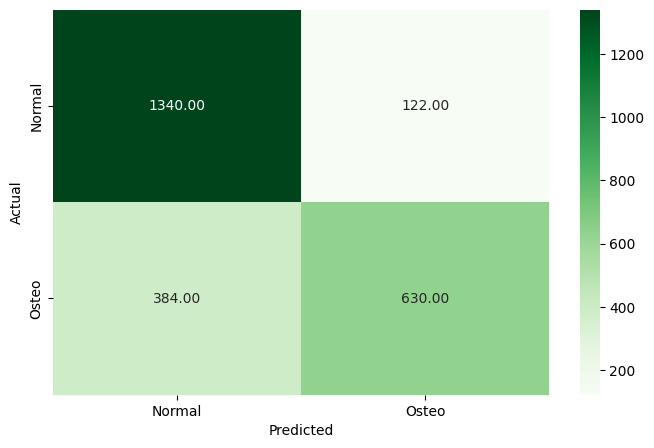

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.65      0.77      0.71       366
         1.0       0.55      0.41      0.47       254

    accuracy                           0.62       620
   macro avg       0.60      0.59      0.59       620
weighted avg       0.61      0.62      0.61       620



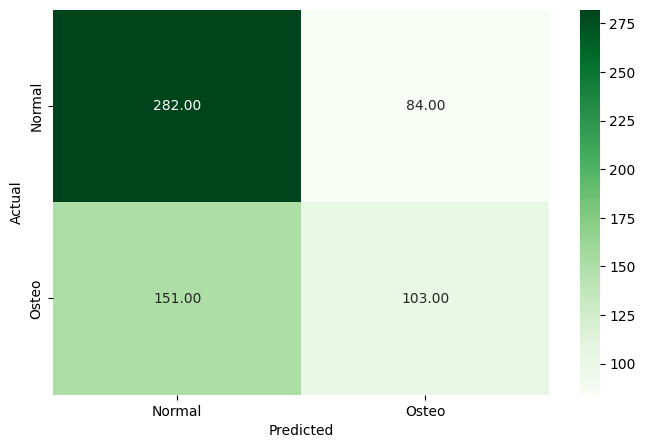

In [122]:
print("TRAIN".center(50))
metrics_score(y_train, dt_model.predict(X_train))
print("TEST".center(50))
metrics_score(y_test, dt_model.predict(X_test))

In [123]:
import numpy as np
from sklearn.model_selection import GridSearchCV

In [124]:
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(random_state = 42)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(1, 7), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fitting the grid search on the train data
gridCV = gridCV.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=1, min_samples_leaf=5,
                       random_state=42)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.75      0.54      0.62      1462
         1.0       0.52      0.74      0.61      1014

    accuracy                           0.62      2476
   macro avg       0.64      0.64      0.62      2476
weighted avg       0.66      0.62      0.62      2476



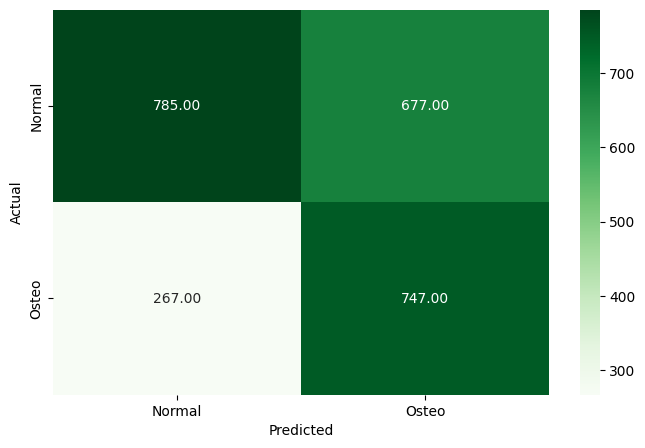

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.76      0.51      0.61       366
         1.0       0.52      0.77      0.62       254

    accuracy                           0.61       620
   macro avg       0.64      0.64      0.61       620
weighted avg       0.66      0.61      0.61       620



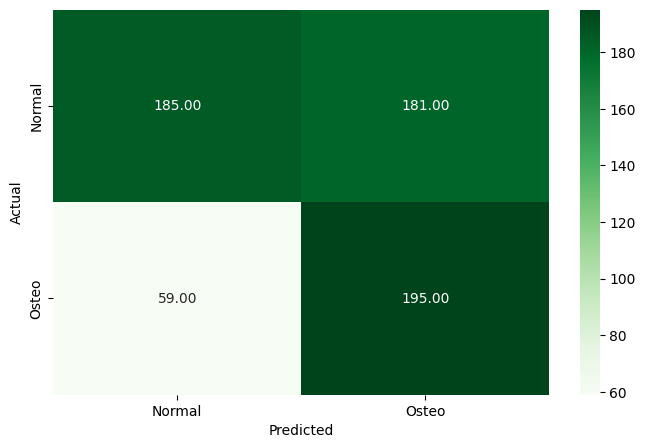

In [125]:
print("TRAIN".center(50))
metrics_score(y_train, dtree_estimator.predict(X_train))
print("TEST".center(50))
metrics_score(y_test, dtree_estimator.predict(X_test))

In [126]:
forest = RandomForestClassifier(random_state = 42)

forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83      1462
         1.0       0.77      0.71      0.74      1014

    accuracy                           0.80      2476
   macro avg       0.79      0.78      0.79      2476
weighted avg       0.79      0.80      0.79      2476



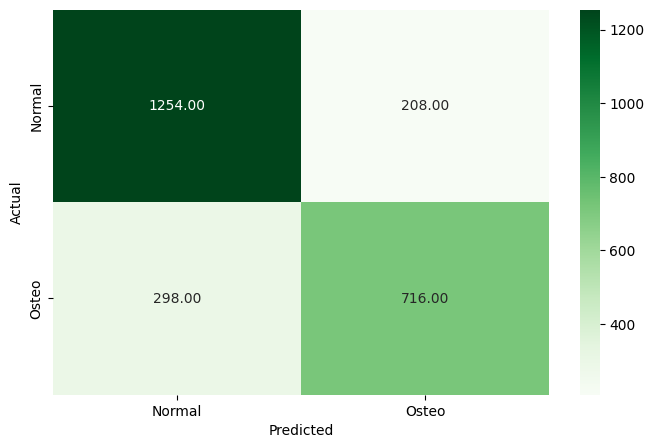

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69       366
         1.0       0.55      0.52      0.53       254

    accuracy                           0.63       620
   macro avg       0.61      0.61      0.61       620
weighted avg       0.62      0.63      0.63       620



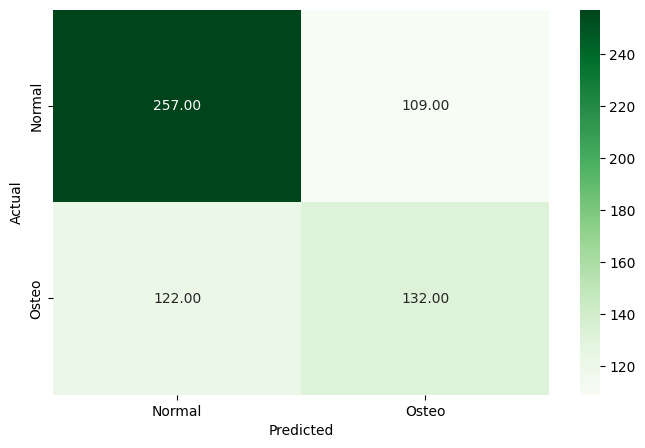

In [127]:
print("TRAIN".center(50))
metrics_score(y_train, forest.predict(X_train))
print("TEST".center(50))
metrics_score(y_test, forest.predict(X_test))

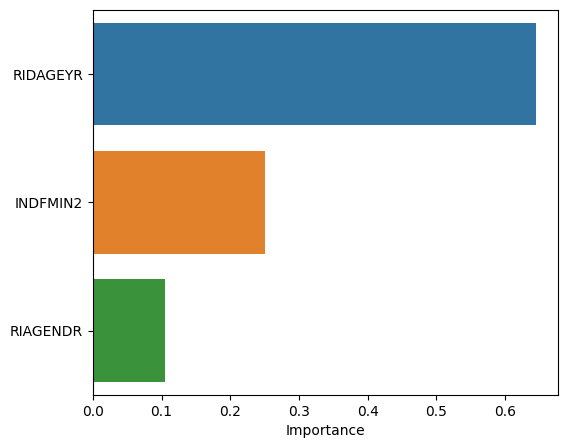

In [128]:
f_importances = forest.feature_importances_
columns = X.columns

f_importance_df = pd.DataFrame(f_importances, index=columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 5))
sns.barplot(data=f_importance_df, x='Importance', y=f_importance_df.index)
plt.show()

In [129]:
tuned_forest = RandomForestClassifier(random_state = 42)

parameters_rf = {
    "n_estimators": [50, 100, 250, 500],
    "min_samples_leaf": range(1, 5),
    "max_features": [*np.arange(0.5, 1, 0.2), 'auto']
}

scorer = make_scorer(recall_score, pos_label=1)

grid_object = GridSearchCV(tuned_forest, parameters_rf, scoring=scorer, cv=10)\
        .fit(X_train, y_train)

tuned_forest = grid_object.best_estimator_

c:\Users\William Costa\Documents\repositories\samsung\nhanes_analysis\.environment\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\William Costa\Documents\repositories\samsung\nhanes_analysis\.environment\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\William Costa\Documents\repositories\samsung\nhanes_analysis\.environment\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c

In [130]:
tuned_forest.fit(X_train, y_train)

RandomForestClassifier(max_features=0.7, min_samples_leaf=2, n_estimators=500,
                       random_state=42)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82      1462
         1.0       0.76      0.66      0.71      1014

    accuracy                           0.78      2476
   macro avg       0.77      0.76      0.76      2476
weighted avg       0.77      0.78      0.77      2476



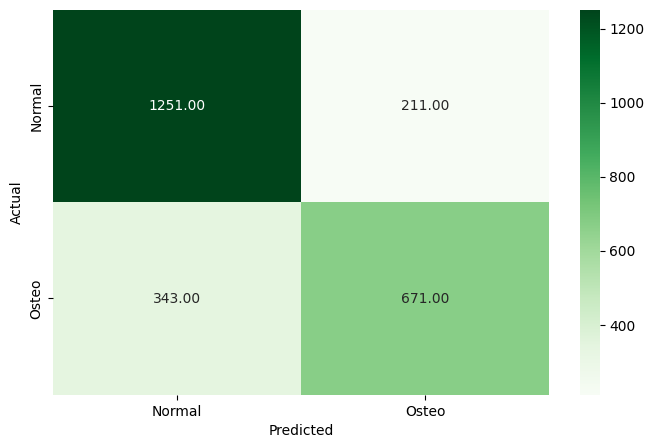

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.69      0.73      0.71       366
         1.0       0.58      0.53      0.55       254

    accuracy                           0.65       620
   macro avg       0.64      0.63      0.63       620
weighted avg       0.65      0.65      0.65       620



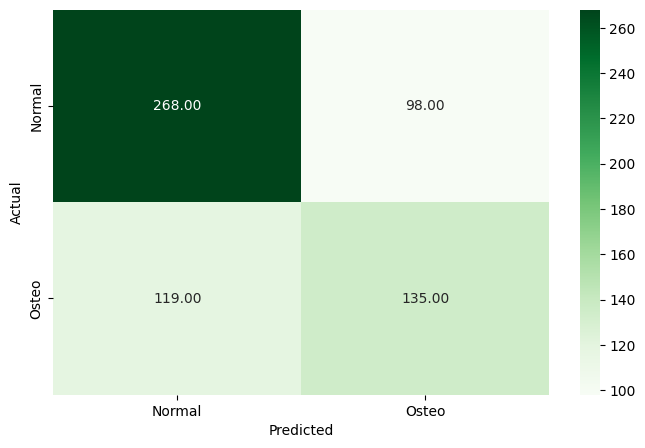

In [131]:
print("TRAIN".center(50))
metrics_score(y_train, tuned_forest.predict(X_train))
print("TEST".center(50))
metrics_score(y_test, tuned_forest.predict(X_test))

<Axes: xlabel='Importance'>

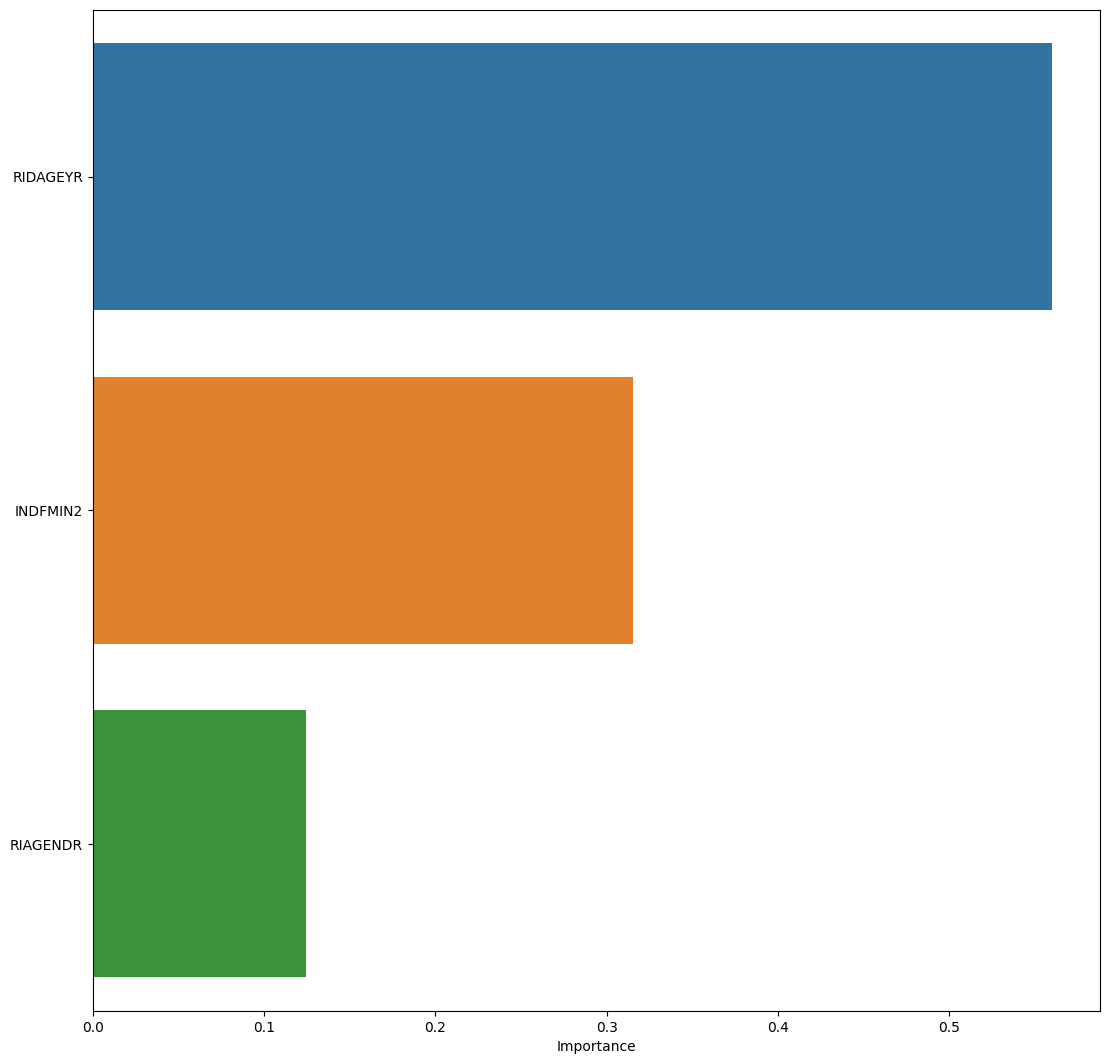

In [132]:
# Plotting feature importance
tf_importances = tuned_forest.feature_importances_
columns = X.columns
tf_importance_df = pd.DataFrame(tf_importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (13, 13))
sns.barplot(data = tf_importance_df, x = tf_importance_df.Importance, y = tf_importance_df.index)

In [133]:
tuned_forest = RandomForestClassifier(random_state = 42)

parameters_rf = {
    "n_estimators": [50, 100, 250, 500],
    "min_samples_leaf": range(1, 5),
    "max_features": [*np.arange(0.5, 1, 0.2), 'auto']
}

scorer = make_scorer(precision_score, pos_label=1)

grid_object = GridSearchCV(tuned_forest, parameters_rf, scoring=scorer, cv=10)\
        .fit(X_train, y_train)

tuned_forest = grid_object.best_estimator_

c:\Users\William Costa\Documents\repositories\samsung\nhanes_analysis\.environment\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\William Costa\Documents\repositories\samsung\nhanes_analysis\.environment\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\William Costa\Documents\repositories\samsung\nhanes_analysis\.environment\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c

In [134]:
tuned_forest.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5, min_samples_leaf=4, random_state=42)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      1462
         1.0       0.74      0.60      0.67      1014

    accuracy                           0.75      2476
   macro avg       0.75      0.73      0.73      2476
weighted avg       0.75      0.75      0.75      2476



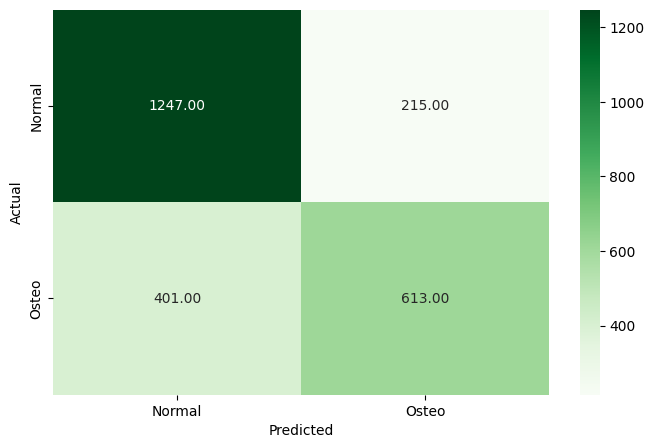

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74       366
         1.0       0.62      0.51      0.56       254

    accuracy                           0.67       620
   macro avg       0.66      0.65      0.65       620
weighted avg       0.67      0.67      0.66       620



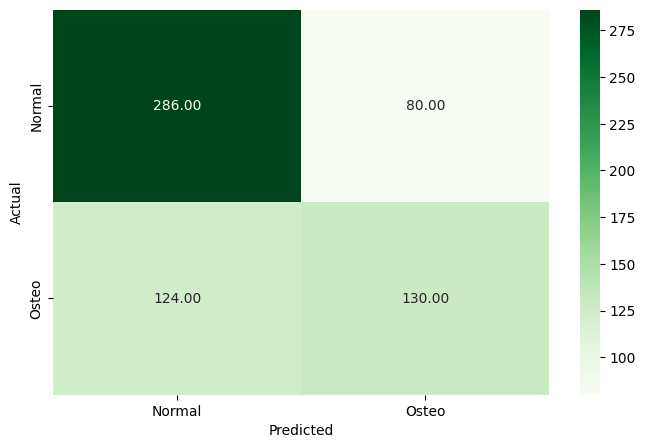

In [135]:
print("TRAIN".center(50))
metrics_score(y_train, tuned_forest.predict(X_train))
print("TEST".center(50))
metrics_score(y_test, tuned_forest.predict(X_test))

<Axes: xlabel='Importance'>

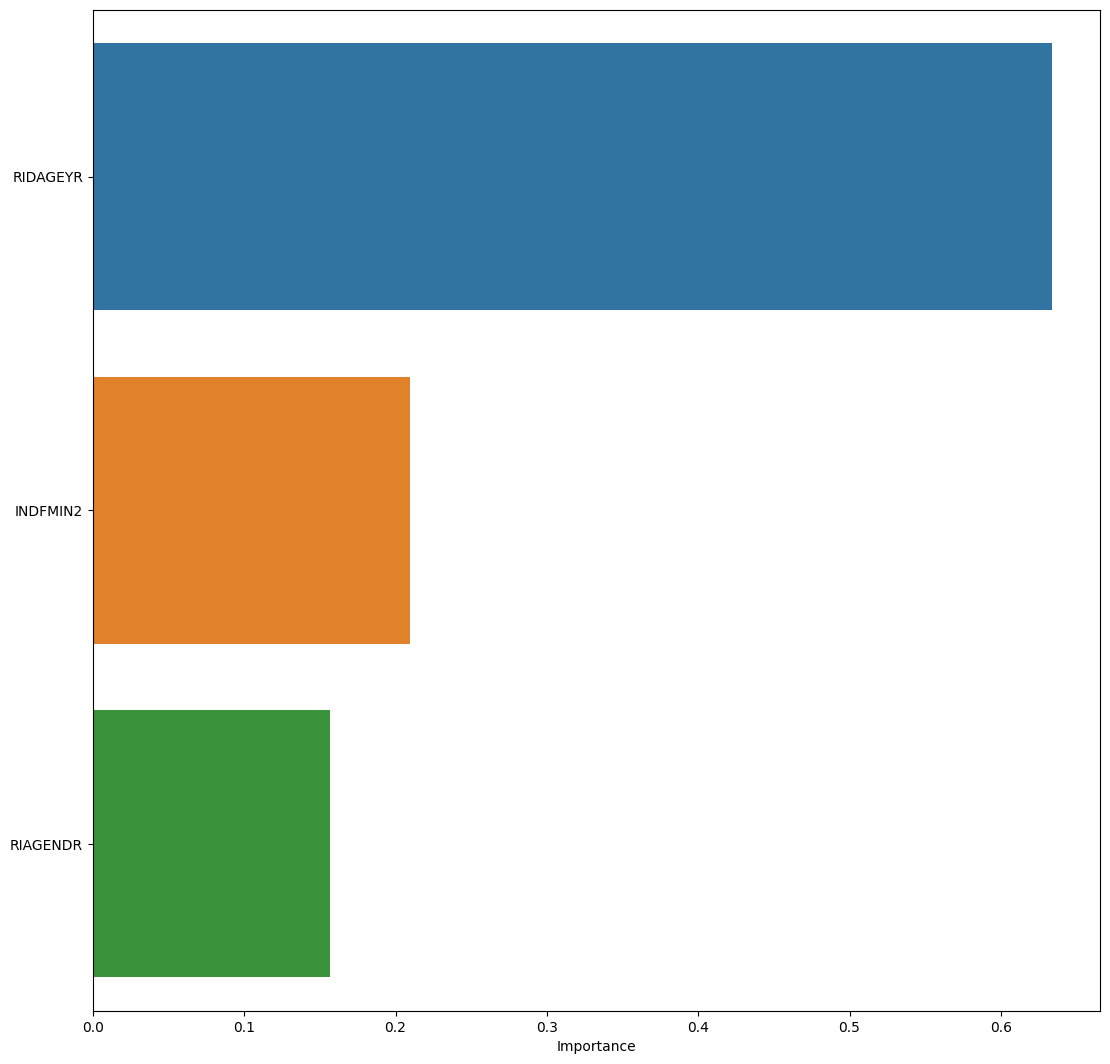

In [136]:
# Plotting feature importance
tf_importances = tuned_forest.feature_importances_
columns = X.columns
tf_importance_df = pd.DataFrame(tf_importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (13, 13))
sns.barplot(data = tf_importance_df, x = tf_importance_df.Importance, y = tf_importance_df.index)